In [1]:
# Não exibir warnings
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr
sys.stderr = sys.__stderr__  # unsilence stderr

In [2]:
#https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/blob/master/Chapter04/main_vgg16.py

from keras.applications.xception import Xception
from keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

In [4]:
batch = 32
#num_train = 5600
#num_validation = 2400

In [5]:
### Transfer Learning ###

xception = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))

# Freeze the pre-trained layers
for layer in xception.layers:
    layer.trainable = False

# Add a fully connected layer with 2 nodes at the end 
input_ = xception.input
output_ = xception(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(2, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
print ("### Estrutura Xception ###")
xception.summary()

print ("\n\n### Estrutura do modelo ###")
model.summary()

### Estrutura Xception ###
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
________________________________________________________________

In [7]:
# Part 2 - Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

#Conjunto de treinamento
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('classificador_B/train',
                                                 target_size = (128, 128),
                                                 color_mode="rgb",
                                                 batch_size = batch,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

print (training_set.class_indices)
#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_B/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle=True)
num_train = training_set.samples
num_validation = validation_set.samples

Found 2800 images belonging to 2 classes.
{'docs_gerais': 0, 'docs_identificacao': 1}
Found 1200 images belonging to 2 classes.


In [8]:
with tf.device('/gpu:0'): #rodar na GPU
    history = model.fit_generator(training_set,
                         steps_per_epoch = (num_train//batch),
                         epochs = 50,
                         validation_data = validation_set,
                         validation_steps = (num_validation//batch), verbose=1)
    

model.save('modelo_classificador_B_Xception.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
87/87 [==============================] - 71s 813ms/step - loss: 0.2575 - accuracy: 0.9321 - val_loss: 0.2102 - val_accuracy: 0.8556
Epoch 2/50
87/87 [==============================] - 76s 873ms/step - loss: 0.1442 - accuracy: 0.9704 - val_loss: 0.3216 - val_accuracy: 0.9015
Epoch 3/50
87/87 [==============================] - 73s 843ms/step - loss: 0.1235 - accuracy: 0.9711 - val_loss: 0.2205 - val_accuracy: 0.9075
Epoch 4/50
87/87 [==============================] - 72s 833ms/step - loss: 0.1173 - accuracy: 0.9722 - val_loss: 0.4272 - val_accuracy: 0.8630
Epoch 5/50
87/87 [==============================] - 76s 870ms/step - loss: 0.0996 - accuracy: 0.9747 - val_loss: 0.3013 - val_accuracy: 0.9170
Epoch 6/50
87/87 [==============================] - 72s 829ms/step - loss: 0.1119 - accuracy: 0.9693 - val_loss: 0.3635 - val_accuracy: 0.9358
Epoch 7/50
87/87 [=============================

Train accuracy: 0.9864
Train loss: 0.0569 

Validation accuracy: 0.8502
Validation loss: 1.0916


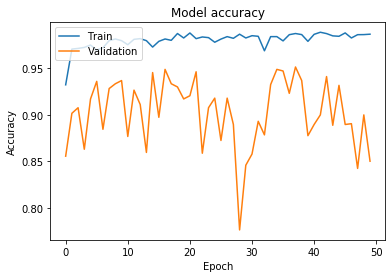

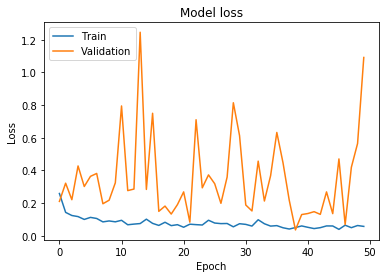

In [9]:
# Final accuracy and loss
print ("Train accuracy: %.4f" % (history.history['accuracy'][-1]))
print ("Train loss: %.4f" % (history.history['loss'][-1]),"\n")

print ("Validation accuracy: %.4f" % (history.history['val_accuracy'][-1]))
print ("Validation loss: %.4f" % (history.history['val_loss'][-1]))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Matriz de confusão para o conjunto de validação ###
Found 1200 images belonging to 2 classes.
37/37 [==============================] - 21s 560ms/step


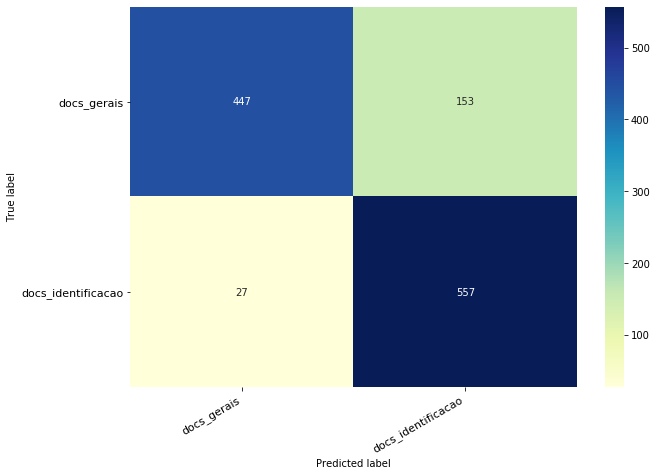

In [10]:
### Conjunto de Validação ###

print ("### Matriz de confusão para o conjunto de validação ###")

#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_B/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle= False)


#Confution Matrix
Y_pred = model.predict_generator(validation_set, num_validation//batch, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = validation_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["docs_gerais","docs_identificacao"], figsize = (10,7), fontsize=11)


### Matriz de confusão para o conjunto de teste ###
Found 600 images belonging to 2 classes.
600/600 [==============================] - 17s 29ms/step
Test accuracy: 0.8300
Test loss: 0.0000


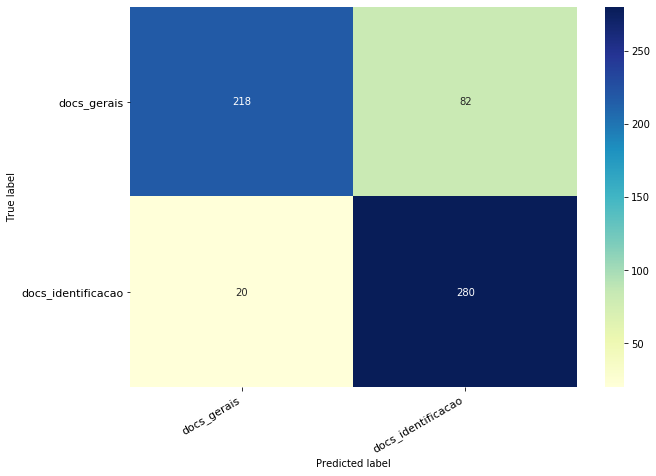

In [11]:
### Conjunto de Teste ###

print ("### Matriz de confusão para o conjunto de teste ###")

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('classificador_B/test/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle=False)
num_test = test_set.samples


#Confution Matrix
Y_pred = model.predict_generator(test_set, num_test, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = test_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["docs_gerais","docs_identificacao"], figsize = (10,7), fontsize=11)

# Accuracy and Loss for the Test set
loss, acc = model.evaluate_generator(test_set, num_test, verbose=1)

# Final accuracy and loss
print ("Test accuracy: %.4f" % acc)
print ("Test loss: %.4f" % loss)
